In [1]:
import os
import sys

import pandas as pd
import numpy as np

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Данные и модель

In [2]:
from dataset import ArchDataset, GT_NEGATIVE_PATHS, GT_POSITIVE_PATHS, GT_NEGATIVE_COORDS, GT_POSITIVE_COORDS

In [3]:
from model import VQVAE

# Параметры модели и обучения

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
results_dir = 'v5'
checkpoint_path = f'{results_dir}/checkpoint_14.pth'

In [6]:
params = {
    'batch_size': 512,
    'img_size': 64,
    'channels': 3,
    'embedding_dim': 64,
    'num_embeddings': 128,
    'beta': 0.25,
    'n_epochs': 15,  # 10
} 

# Датасет

In [7]:
transform_crop_64 = transforms.Compose([
    transforms.CenterCrop((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [8]:
train_dataset = ArchDataset(
    img_paths=GT_NEGATIVE_PATHS, 
    coords=GT_NEGATIVE_COORDS, 
    anomalies=False, 
    transform=transform_crop_64
)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

anomalies_dataset = ArchDataset(
    img_paths=GT_POSITIVE_PATHS, 
    coords=GT_POSITIVE_COORDS, 
    anomalies=False, 
    transform=transform_crop_64
)
anomalies_loader = DataLoader(anomalies_dataset, batch_size=params['batch_size'], shuffle=False)

In [9]:
print(f'train: {len(train_dataset)} images, {len(train_loader)} batches')
print(f'anomalies: {len(anomalies_dataset)} images, {len(anomalies_loader)} batches')

train: 139945 images, 274 batches
anomalies: 163 images, 1 batches


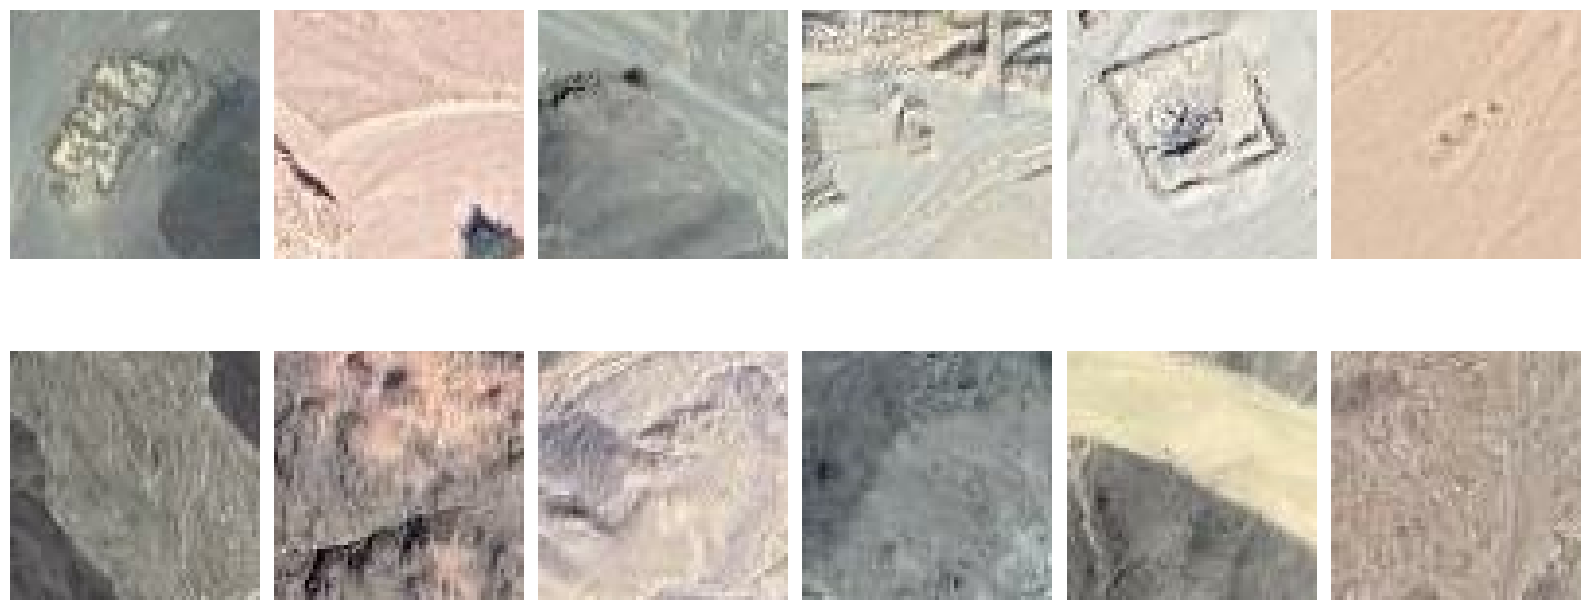

In [10]:
ncols = 6

fig, axs = plt.subplots(nrows=2, ncols=ncols, figsize=(16, 8))
for i in range(ncols):
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[0, i].imshow((anomalies_dataset[i][0].permute(1, 2, 0) + 1) / 2)
    axs[1, i].imshow((train_dataset[i][0].permute(1, 2, 0) + 1) / 2)
fig.tight_layout()
fig.show()

# Создание модели

In [11]:
model = VQVAE(
    in_channels=params['channels'],
    img_size=params['img_size'],
    
    embedding_dim=params['embedding_dim'],
    num_embeddings=params['num_embeddings'],
    beta=params['beta']
)
model.to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

# Метрики

In [12]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex')

from torchvision.models import vit_b_16, ViT_B_16_Weights


weights = ViT_B_16_Weights.IMAGENET1K_V1
vit_model = vit_b_16(weights=weights)
vit_model.to(device)

vit_model.heads = torch.nn.Identity()
vit_model.eval();

from sklearn.metrics.pairwise import cosine_similarity

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /tmp/xdg_cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 65.7MB/s] 


Loading model from: /home/jupyter/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 63.5MB/s] 


In [13]:
def load_image(names):
    imgs = []
    for name in names:
        img = transform_crop_64_grayscale(Image.open(name).convert('RGB'))
        imgs.append(img)
    return imgs

def align_image(img):
    return (img - img.min()) / (img.max() - img.min())

def draw_image(imgs):
    fig, axes = plt.subplots(ncols=len(imgs) , figsize=(len(imgs) * 2, 2))

    if len(imgs) == 1:
        img = imgs[0]
        cmap = 'gray' if img.shape[0] == 1 else None
        axes.imshow(align_image(img).permute(1, 2, 0), cmap=cmap)
    else:
        for i, img in enumerate(imgs):
            cmap = 'gray' if img.shape[0] == 1 else None
            axes[i].imshow(align_image(img).permute(1, 2, 0), cmap=cmap)
    plt.show()

In [14]:
def vit_cosine_similarity(img1, img2):

    assert len(img1.shape) == len(img2.shape) == 3,\
        f'expected images of shape C x W x H, got {img1.shape=} {img2.shape=}'

    assert img1.shape[0] == img2.shape[0],\
        f'different number of channels: {img1.shape[0]=} {img2.shape[0]=}'
    

    if img1.shape[0] == 1:  # grayscale
        img1 = img1.repeat(3, 1, 1)
        img2 = img2.repeat(3, 1, 1)

    resize = transforms.Resize(size=224, antialias=True)

    img1 = resize(img1.unsqueeze(0))
    img2 = resize(img2.unsqueeze(0))

    features1 = vit_model(img1).cpu().detach().numpy()
    features2 = vit_model(img2).cpu().detach().numpy()

    sim = cosine_similaritymilarity(features1, features2)
    return sim[0, 0].item()


In [21]:
def test(real_img, return_img=False):
    
    real_img_cuda = real_img.to(device)
    reconstructed_img_cuda = model(real_img_cuda[None, :])[0][0]

    sim = vit_cosine_similarity(real_img_cuda, reconstructed_img_cuda)
    
    if return_img:
        return sim, reconstructed_img_cuda.cpu()
    else:
        return sim
    

In [16]:
anomaly_dataset_scores = []
for img, idx, coords, anomaly_flag in tqdm(anomalies_dataset, total=len(anomalies_dataset)):
    sim = test(img)
    anomaly_dataset_scores.append(sim)

100%|██████████| 163/163 [00:38<00:00,  4.28it/s]


In [28]:
train_dataset_scores = []
for img, idx, coords, anomaly_flag in tqdm(train_dataset, total=len(train_dataset)):
    sim = test(img)
    train_dataset_scores.append(sim)
    if idx > 1000:
        break

  1%|          | 1001/139945 [03:53<8:59:26,  4.29it/s]


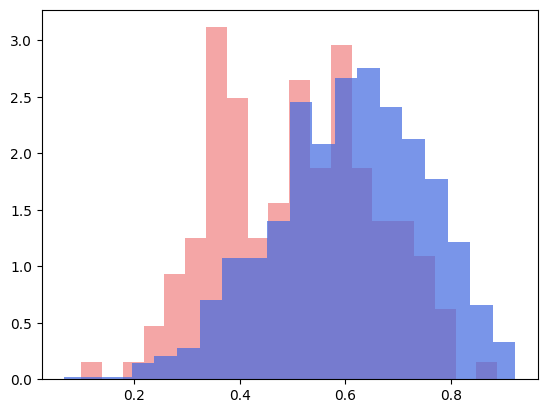

In [37]:
plt.hist(anomaly_dataset_scores, bins=20, color='lightcoral', alpha=0.7, density=True)
plt.hist(train_dataset_scores, bins=20, color='royalblue', alpha=0.7, density=True);

In [30]:
anomaly_dataset_scores = np.array(anomaly_dataset_scores)
train_dataset_scores = np.array(train_dataset_scores)

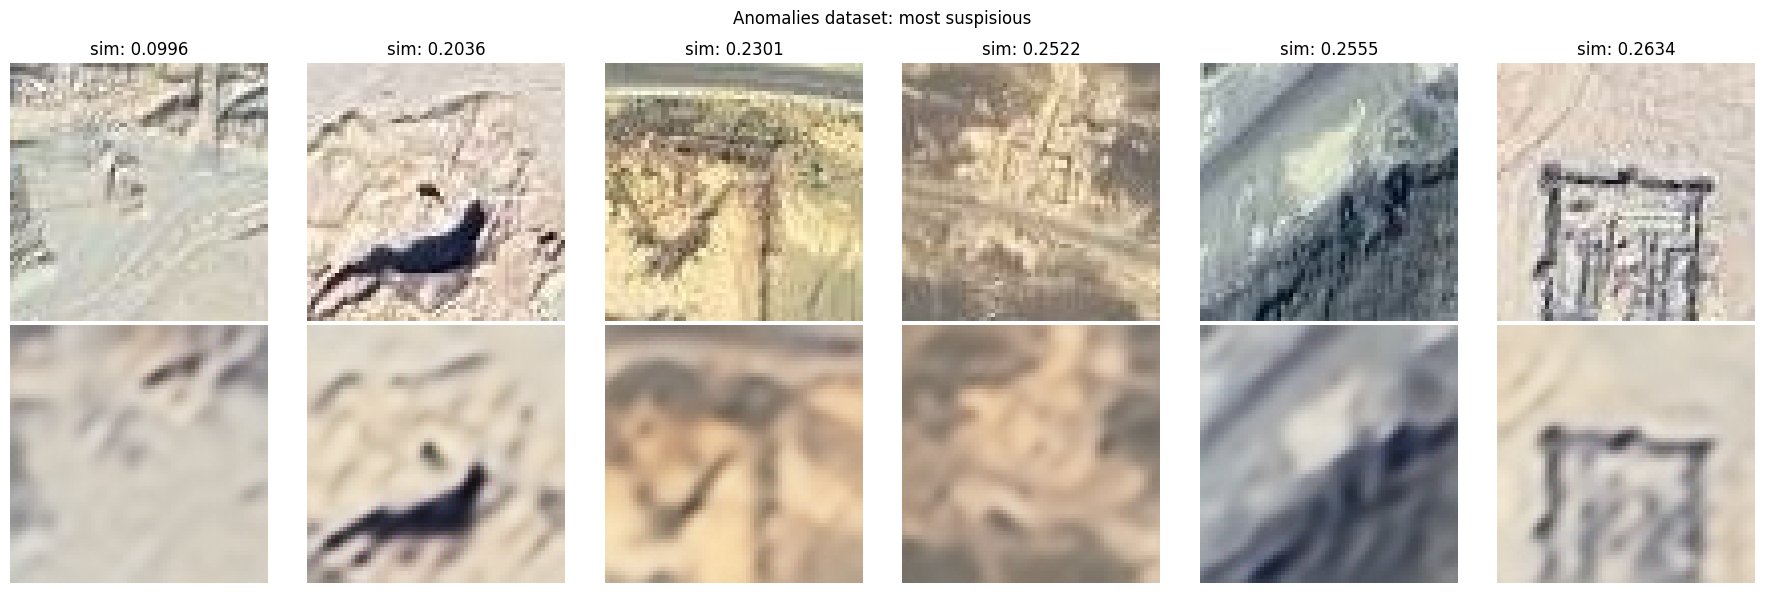

In [31]:
anomalies_sorted_idxs = np.argsort(anomaly_dataset_scores)
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Anomalies dataset: most suspisious')

for j in range(ncols):
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    idx = anomalies_sorted_idxs[j]
    img = anomalies_dataset[idx][0]
    sim, reconstructed_img = test(img, return_img=True)

    axs[0, j].imshow((img.permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((reconstructed_img.permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'sim: {sim:.4f}')
    
fig.tight_layout()
fig.show()

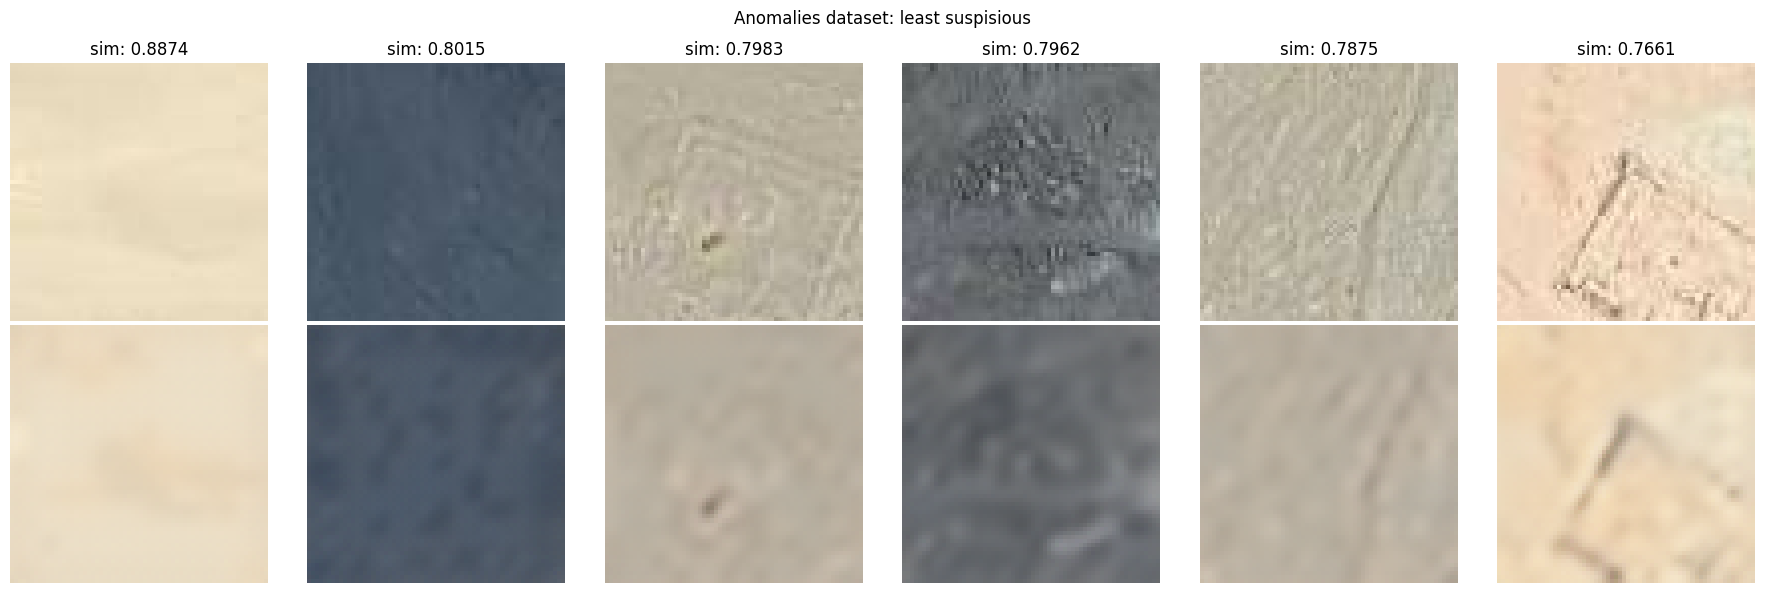

In [32]:
anomalies_sorted_idxs = np.argsort(anomaly_dataset_scores)
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Anomalies dataset: least suspisious')

for j in range(ncols):
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    idx = anomalies_sorted_idxs[-(j + 1)]
    img = anomalies_dataset[idx][0]
    sim, reconstructed_img = test(img, return_img=True)

    axs[0, j].imshow((img.permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((reconstructed_img.permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'sim: {sim:.4f}')
    
fig.tight_layout()
fig.show()

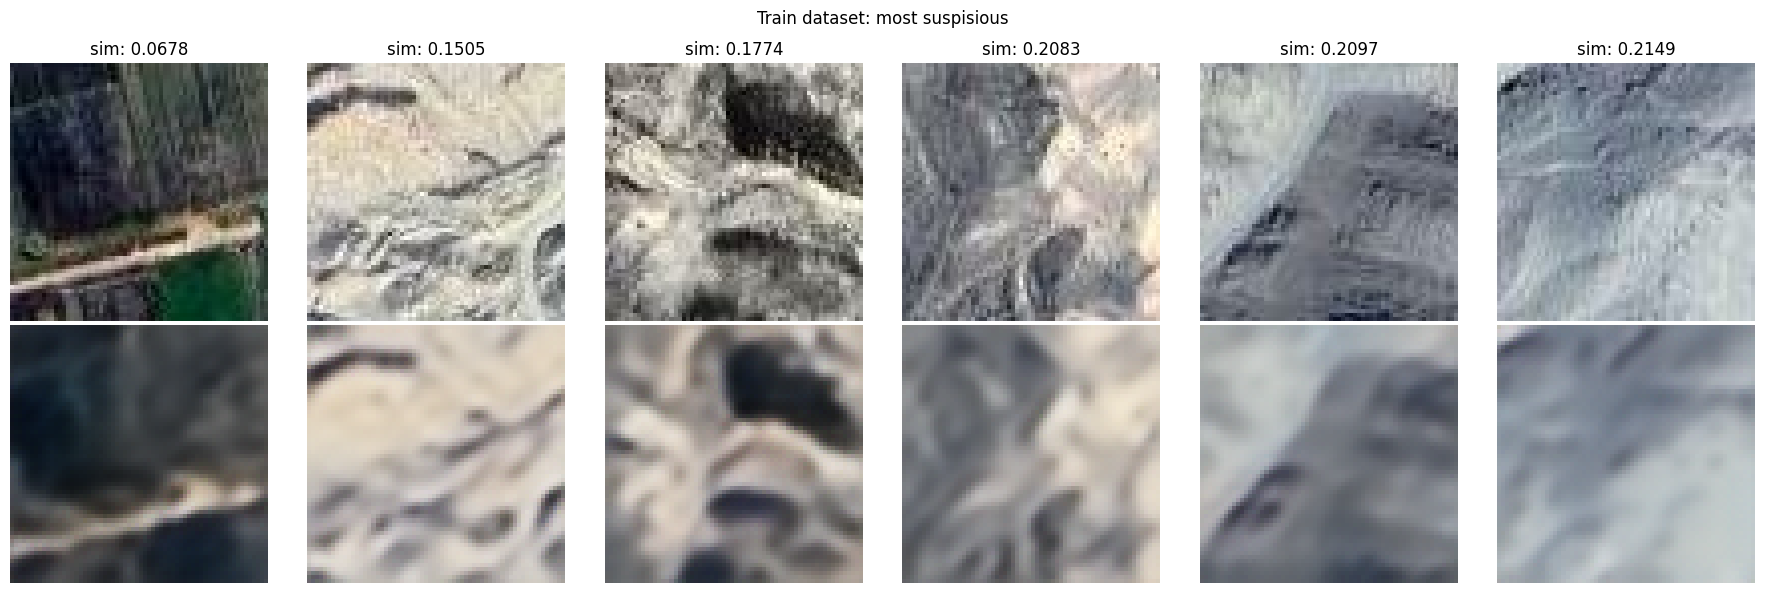

In [33]:
train_sorted_idxs = np.argsort(train_dataset_scores)
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Train dataset: most suspisious')

for j in range(ncols):
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    idx = train_sorted_idxs[j]
    img = train_dataset[idx][0]
    sim, reconstructed_img = test(img, return_img=True)

    axs[0, j].imshow((img.permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((reconstructed_img.permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'sim: {sim:.4f}')
    
fig.tight_layout()
fig.show()

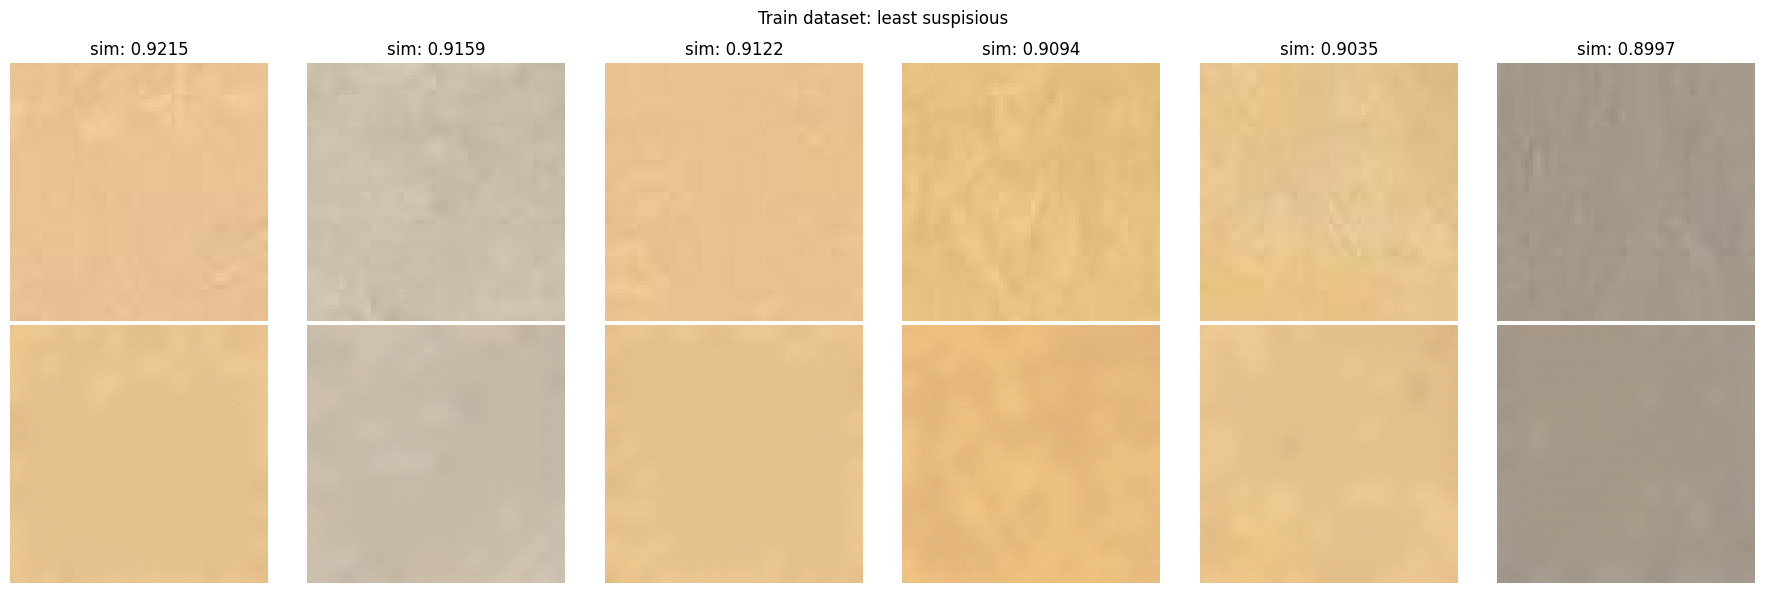

In [34]:
train_sorted_idxs = np.argsort(train_dataset_scores)
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Train dataset: least suspisious')

for j in range(ncols):
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    idx = train_sorted_idxs[-(j+1)]
    img = train_dataset[idx][0]
    sim, reconstructed_img = test(img, return_img=True)

    axs[0, j].imshow((img.permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((reconstructed_img.permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'sim: {sim:.4f}')
    
fig.tight_layout()
fig.show()

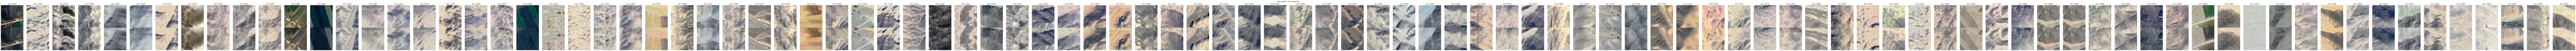

In [35]:
train_sorted_idxs = np.argsort(train_dataset_scores)
nrows, ncols = 2, 100

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Train dataset: most suspisious')

for j in range(ncols):
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    idx = train_sorted_idxs[j]
    img = train_dataset[idx][0]
    sim, reconstructed_img = test(img, return_img=True)

    axs[0, j].imshow((img.permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((reconstructed_img.permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'sim: {sim:.4f}')
    
fig.tight_layout()
fig.show()